# Домашнее задание 2 
## Contrastive and non-contrastive methods in CXR images

## Оценивание

Задание должно быть выполнено самостоятельно. Похожие решения будут считаться плагиатом. Если вы опирались на внешний источник в реализации, необходимо указать ссылку на него. 

В качестве решения, необходимо предоставить код + отчет, в котором будут отображены все детали выбора гиперпараметров, комментарии, сопровождающие графики, а так же ответы на вопросы в ДЗ. Оформляйте отчет четко и читаемо. Плохо оформленный код, плохо оформленные графики негативно скажутся на оценке, так же как и неэффективная реализация.

## Введение

Вам предстоит реализовать и поработать с двумя методами - [SimCLR](https://arxiv.org/abs/2002.05709) и [VICReg](https://arxiv.org/abs/2105.04906). Обучать их будем на датасете, относящемся к домену медицинских изображений. Ниже подробнее про датасеты и сетап.


### Датасеты [MedMNIST+](https://medmnist.com/)
Будем использовать уже подготовленные сконвертированные из DICOM'ов картинки. MedMNIST включает в себя два релевантных для нас датасета с рентгеновскими снимками грудной клетки:


| MedMNIST2D     | Data Modality | Tasks (# Classes/Labels)           | # Samples | # Training | # Validation | # Test |
|----------------|---------------|------------------------------------|-----------|------------|--------------|--------|
| ChestMNIST     | Chest X-Ray   | Multi-Label (14), Binary-Class (2) | 112,120   | 78,468     | 11,219       | 22,433 |
| PneumoniaMNIST | Chest X-Ray   | Binary-Class (2)                   | 5,856     | 4,708      | 524          | 624    |

На этот раз будем использовать разрешение 224x224 (необходимо выставить `size` при инициализации датасета). Несколько картинок из ChestMNIST:

![CXR image examples from ChestMNIST](cxr.png)

## Задание 0 
(2 балла)

Реализуйте SimCLR и VICReg на базе ResNet-18 энкодера. Для этого надо реализовать соответствующие лосс-функции и архитектуры проекционных голов. Убедитесь, в корректности реализации на CIFAR-10 (не забудьте применить коррекцию резнета для картинок разрешением 32x32 из предыдущего домашнего задания). Для этого, сначала сделайте предобучение на train части датасета в течении 100 эпох, затем сделайте линейный пробинг с замороженным выучившимся энкодером.

Референсный интервал top-1 accuracy для 100 эпох предобучения ~80-83% на линейном пробинге (если не получается, проверьте реализацию оптимизатора (LARS) и расписания шага обучения (`warmup_cosine`) или попробуйте подвигать learning rate).

## Задание 1
(1 балл)

Загрузите датасеты и проанализируйте данные. Например, посмотрите на количество и баланс классов, как устроена разметка по классам, найдите среднее и дисперсию значений пикселей. Определите подходящие метрики и лосс для конечной задачи для каждого из датасетов, аргументировано объясните ваш выбор.

In [3]:
# %pip install medmnist
from medmnist import ChestMNIST, PneumoniaMNIST

chestmnist = ChestMNIST(split='train', download=True, as_rgb=False, size=224)
pneumoniamnist = PneumoniaMNIST(split='train', download=True, as_rgb=False, size=224)

Using downloaded and verified file: C:\Users\sever\.medmnist\chestmnist_224.npz
Using downloaded and verified file: C:\Users\sever\.medmnist\pneumoniamnist_224.npz


In [9]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

### Pneumoniamnist:

In [5]:
from collections import Counter
images, labels = pneumoniamnist.imgs, pneumoniamnist.labels

# Есть дисбаланс классов
class_counts = Counter(labels.flatten())
print("Распределение классов:")
for cls, count in class_counts.items():
    print(f"Класс {cls}: {count} изображений")

Распределение классов:
Класс 1: 3494 изображений
Класс 0: 1214 изображений


In [23]:
scaled_images = images / 255.0
mean_pixel = np.mean(scaled_images)
variance_pixel = np.var(scaled_images)
print(f"\nСреднее значение пикселей: {mean_pixel:.4f}")
print(f"Дисперсия значений пикселей: {variance_pixel:.4f}")


Среднее значение пикселей: 0.5717
Дисперсия значений пикселей: 0.0313


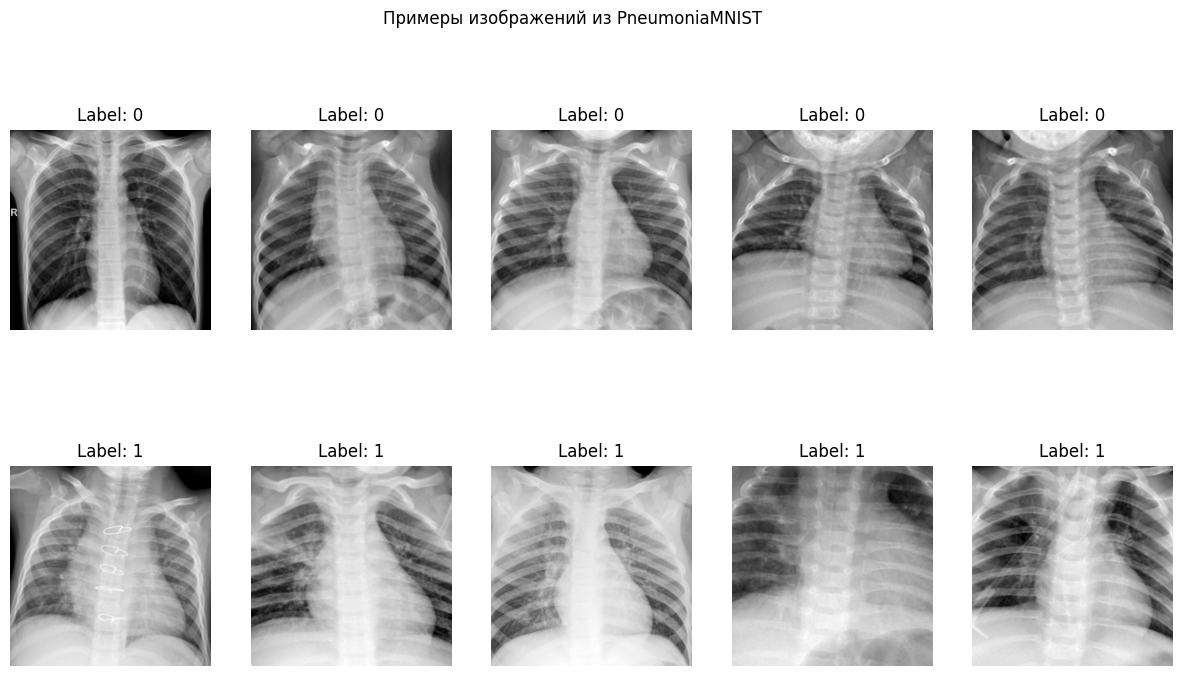

In [17]:
def plot_examples_with_different_labels(images, labels, title, num_examples=10):
    plt.figure(figsize=(15, 8))
    unique_labels = np.unique(labels)
    examples = []

    for label in unique_labels:
        idx = np.where(labels.flatten() == label)[0]
        examples.extend(idx[:num_examples // len(unique_labels)])

    examples = examples[:num_examples]

    for i, idx in enumerate(examples):
        plt.subplot(2, (num_examples + 1) // 2, i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title(f"Label: {labels[idx][0]}")
        plt.axis('off')

    plt.suptitle(title)
    plt.show()

plot_examples_with_different_labels(images, labels, "Примеры изображений из PneumoniaMNIST", num_examples=10)

### ChestMNIST:

In [4]:
# Данные не очень хорошо сбалансированы
import numpy as np
images, labels = chestmnist.imgs, chestmnist.labels
class_counts = np.sum(labels, axis=0) 
print("Распределение классов (количество меток по каждому классу):")
for cls, count in enumerate(class_counts):
    print(f"Класс {cls}: {count} меток")

Распределение классов (количество меток по каждому классу):
Класс 0: 7996 меток
Класс 1: 1950 меток
Класс 2: 9261 меток
Класс 3: 13914 меток
Класс 4: 3988 меток
Класс 5: 4375 меток
Класс 6: 978 меток
Класс 7: 3705 меток
Класс 8: 3263 меток
Класс 9: 1690 меток
Класс 10: 1799 меток
Класс 11: 1158 меток
Класс 12: 2279 меток
Класс 13: 144 меток


In [6]:
scaled_images = images / 255.0
mean_pixel = np.mean(scaled_images)
variance_pixel = np.var(scaled_images)
print(f"\nСреднее значение пикселей: {mean_pixel:.4f}")
print(f"Дисперсия значений пикселей: {variance_pixel:.4f}")



Среднее значение пикселей: 0.4979
Дисперсия значений пикселей: 0.0615


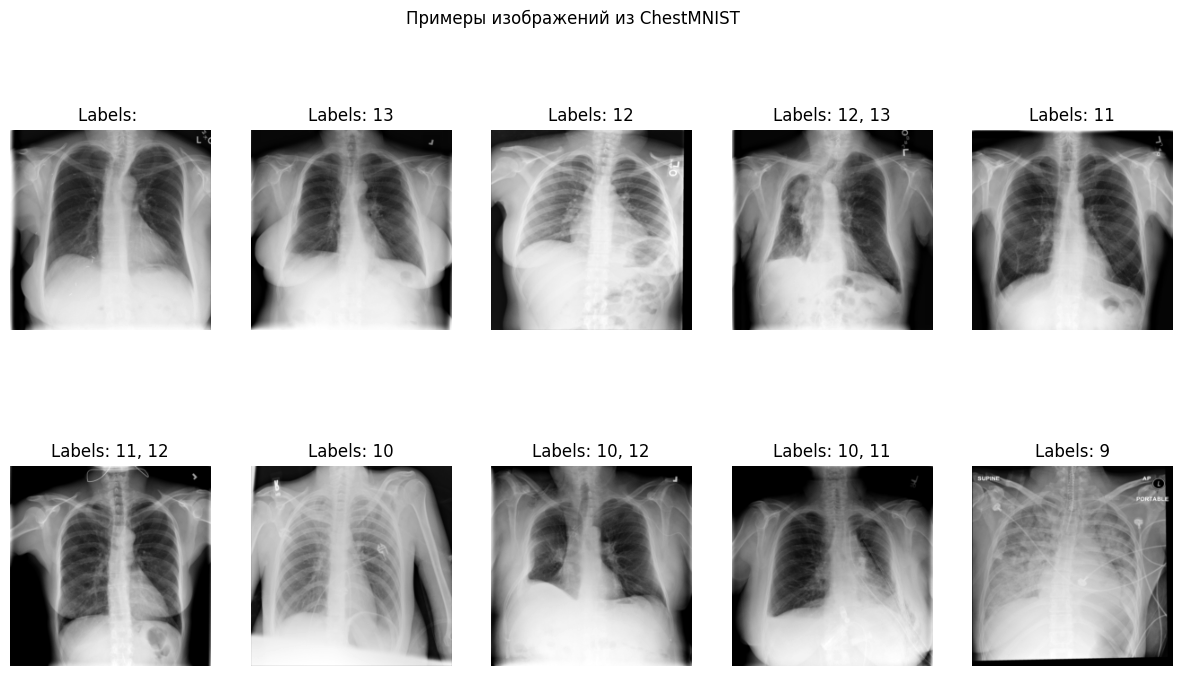

In [29]:
def plot_multilabel_examples(images, labels, title, num_examples=10):
    """
    Отображение примеров изображений с разными комбинациями меток для мульти-лейбл задачи.
    """
    plt.figure(figsize=(15, 8))
    unique_labels, indices = np.unique(labels, axis=0, return_index=True)  # Уникальные комбинации меток
    examples = indices[:num_examples]  # Ограничиваем количество примеров

    for i, idx in enumerate(examples):
        plt.subplot(2, (num_examples + 1) // 2, i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        label_text = ", ".join([f"{j}" for j, l in enumerate(labels[idx]) if l == 1])  # Преобразуем метки в текст
        plt.title(f"Labels: {label_text}")
        plt.axis('off')

    plt.suptitle(title)
    plt.show()

# Вызов функции
plot_multilabel_examples(images, labels, "Примеры изображений из ChestMNIST", num_examples=10)


## Задание 2
(2 балла)

CXR изображения выглядят специфично. Кажется, что нужно иметь и специфичные для таких картинок аугментации.
Поиграйтесь с трансформами и зафиксируйте набор аугментаций, с которым вы будете проводить финальные запуски предобучения.

### Каким образом можно определить подходящие аугментации?

За неимением экспертного знания (если есть знакомый врач-рентгенолог, можно посоветоваться), будем отталкиваться от набора аугментаций в естественных картинках. Начнем с набора, используемого в SimCLR-подобных методах, для ImageNet. Примерно так готовый набор выглядит в `torchvision`'е (обратите внимание, что при создании `СolorJitter` указываются не сами интвервалы, а дельта, т.е. `brightness=0.4` дает `(0.6, 1.4)`):

```python
Compose(
      RandomResizedCrop(
          size=(224, 224),
          scale=(0.08, 1.0),
          ratio=(0.75, 1.3333333333333333),
          interpolation=InterpolationMode.BICUBIC,
          antialias=True)
      RandomApply(
          ColorJitter(
              brightness=(0.6, 1.4),
              contrast=(0.6, 1.4),
              saturation=(0.8, 1.2),
              hue=(-0.1, 0.1)))
      RandomGrayscale(p=0.2)
      GaussianBlur(p=0.5)
      Solarization(p=0.1)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.228, 0.224, 0.225], inplace=False)
```

Какие параметры аугментаций стоило бы поменять? Реализуйте набор трансформов, посмотрите какие картинки получаются на выходе (не забудьте перевести выход в нужный интервал значений для визуализации), поиграйтесь со значениями параметров (например, `scale` в `RandomResizedCrop` или `brightness` в `ColorJitter`). Какие трансформы стоит убрать?

Следующий шаг - добавление аугментаций. Добавьте инвертирование и повороты картинок на небольшой угол (найдите подходящие готовые трансформы или функции для их реализации в `torchvision` или `albumentations`).

## Задание 3
(2 балла)

Для того, чтобы честно найти подходящий набор аугментаций, надо проводить этап предобучения и затем оценивать качество получившихся репрезентаций на конечной задаче. Давайте немного ускорим этот процесс с помощью online probing'a.

Для этого, добавим голову для линейного пробинга `linear_probe` к нашему энкодеру (`backbone`) и проекционной голове (`projection_head`). Эта линейная "проба" будет состоять просто из одного линейного слоя из размерности выхода энкодера (например, 512 для ResNet18) в число классов на конечной задаче (например, 14 классов у ChestMNIST).

На каждой итерации предобучения будем учить `backbone` и `projection_head` на претекстовую задачу (например, SimCLR лосс), а линейную пробу на классификацию. Получается такая двуглавая архитектура, где градиенты с претектового лосса текут по проекционной голове и энкодеру, а градиенты с классификационного лосса только по линейной пробе (не забудьте правильно `detach'`нуться).

```
                      projection_head(h) -> ssl_loss
                    /
x -> encoder(x) -> h
                    \
                      probe(h.detach()) -> classification_loss
```

Таким образом, мы сможем в реальном времени наблюдать за тем, как обучение на претекстовую задачу влияет на качество репрезентаций для конечной задачи. Конечно, это не то же самое, что провести полный цикл предобучения, а затем измерить качество на конечной задаче. Тем не менее, это обеспечивает быструю итерацию по конфигурациям гиперпараметров (например, выбор аугментаций), так как качество на онлайн пробинге сильно коррелирует с финальным пробингом. К примеру, можно запускать обучение на `n` эпох (не забудьте откорректировать минимальное значение  learning rate'а как если бы вы обучались на 100 эпох) и сравнивать онлайн метрики на `n`-ой эпохе, где `n=20`.

Реализуйте онлайн пробинг и используйте его для отбора аугментаций. В качестве аргументации выбора финального набора, в отчете продемонстрируйте графики с метриками онлайн пробинга для нескольких запусков с разными наборами аугментаций.

## Задание 4
(2 балла)

Перейдем к финальному предобучению. 
В качестве референсного набора зафиксируем следующую композицию трансформов:

```python
Compose(
      RandomApply(    
          RandomRotation(degrees=[-10.0, 10.0],
          interpolation=InterpolationMode.NEAREST,
          expand=False,
          fill=0))
      RandomResizedCrop(
          size=(224, 224),
          scale=(0.5, 1.0),
          ratio=(0.75, 1.3333333333333333),
          interpolation=InterpolationMode.BICUBIC, antialias=True)
      RandomApply(    
          ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2)))
      RandomHorizontalFlip(p=0.5)
      RandomApply(    
          Lambda(<lambda>, types=['object']))
      ToTensor()
      Normalize(mean=[0.5], std=[0.5], inplace=False)
),
```
где `<lambda>` это функция для инвертирования изображения.
Сравните выбранный вами набор аугментаций и референсный, какой из них лучше? Для сравнения можете ориентироваться на метрики онлайн пробинга на 20 эпохе.

Лучшую композицию теперь используйте в предобучении на 100 эпохах двух реализованных вами методов из **задания 0**: SimCLR и VICReg (не забудьте использовать версию ResNet18 для разрешения 224х224).
После предобучения проведите линейный пробинг на всех датасетах (ChestMNIST и PneumoniaMNIST). В отчете продемонстрируйте графики обучения (значение лосса, значение метрик онлайн пробинга в ходе обучения), а также таблицу с финальными результатами.

**Бонусный балл** получат решения, у которых значения финальных метрик соответсвуют supervised качеству (т.е. как если бы вы обучали ResNet-18 с нуля на каждом датасете). Значения метрик при supervised обучении можно найти [здесь](https://medmnist.com/). 

## Задание 5
(1 балл)

Попробуем начать предобучение не с рандомной инициализации, а с весов, полученных предобучением на естественных картинках. Предлагается два варианта на выбор (надо выбрать один):
* веса из библиотеки `torchvision`, которые были получены supervised обучением,
* веса из соответствующих чекпоинтов [solo-learn](https://github.com/vturrisi/solo-learn/tree/main), которые были получены self-supervised обучением на Imagenet-100 (100-классовая подвыборка ImageNet'а).

Для этого при создании энкодера в `torchvision.models.resnet` можно использовать параметр `weights` у `resnet18()`. 
После инициализации с предобученных весов, проведите такой же цикл предобучения из предыдущего пункта, и продемонстрируйте разницу в финальном качестве. Помогает или вредит старт с supervised imagenet'овских весов?